El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_3727418/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "MetaCartel - MetaCartel Ventures"
ORG_PLATFORM = ["daohaus", "snapshot"]
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = "2020-11-06"


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 3287 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3287 entries, 0 to 3286
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       3287 non-null   object        
 1   name           3287 non-null   object        
 2   id             3287 non-null   object        
 3   proposal       3287 non-null   category      
 4   deployment     3287 non-null   object        
 5   platform_vote  3287 non-null   object        
 6   voter          3287 non-null   category      
 7   date           3287 non-null   datetime64[ns]
 8   choice         3287 non-null   object        
 9   weight         2868 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 252.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 934 entries, 0 to 933
Data columns (total 13 columns):
 #   Column               Non-Null Coun

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,b23fab43-3b08-5638-b13d-0e286cadb04b,2020-04-01 03:11:46,1
1,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,18f8c9fd-9796-5802-ab78-b449c65ffb50,2020-06-17 03:08:43,1
2,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,2a062f74-c7cb-5625-b8ba-537b23ae5318,2019-07-25 20:06:53,1
3,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,3eff52ec-93aa-5c41-9ff2-3a18d278d138,2019-07-30 18:13:46,1
4,0x0eabffd8ce94ab2387fc44ba32642af0c58af433,b21a24a0-1a16-55a1-8c0e-c97ed7cf8e69,2019-08-06 18:25:25,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                           792
mean     17 days 06:20:59.819444444
std      10 days 08:34:23.805048907
min                 2 days 00:05:31
25%         14 days 07:18:08.750000
50%                15 days 22:19:58
75%         18 days 19:26:56.250000
max               176 days 03:55:05
dtype: object

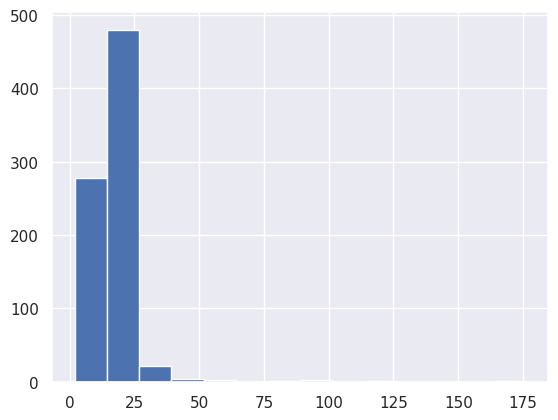

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

In [7]:
delta.value_counts()

7 days 00:00:00     28
3 days 00:00:00      6
15 days 20:30:00     4
6 days 00:00:00      4
15 days 20:29:12     4
                    ..
18 days 13:44:09     1
16 days 07:11:48     1
16 days 07:04:11     1
20 days 22:17:23     1
3 days 06:37:04      1
Length: 746, dtype: int64

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

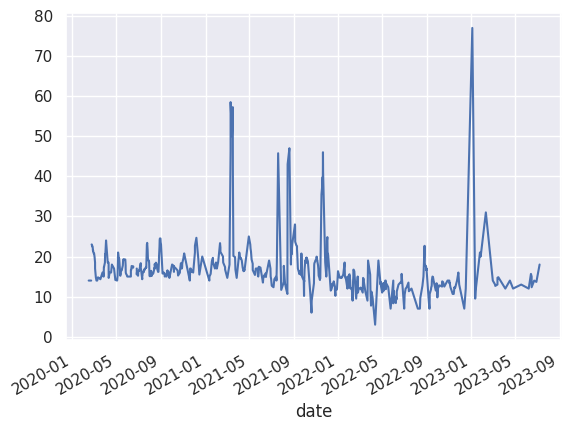

In [8]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Tuesday      240
Thursday     158
Wednesday    146
Monday       139
Friday       124
Saturday      64
Sunday        63
Name: start, dtype: int64

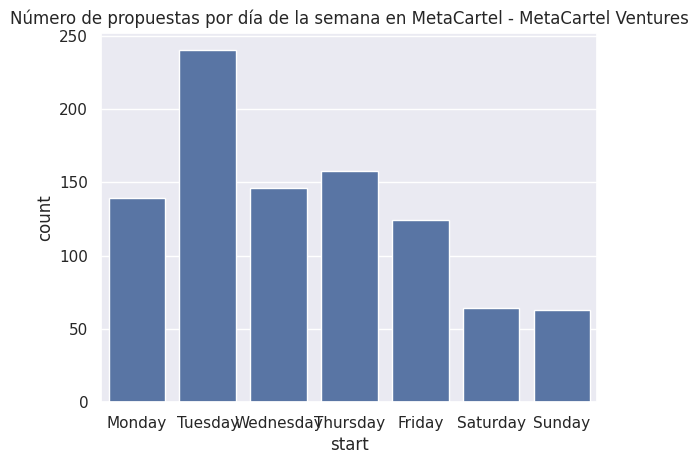

In [9]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Text(0, 0.5, '')

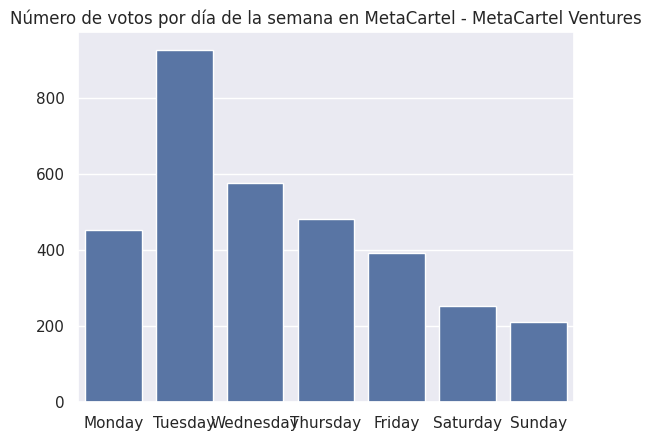

In [10]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()
plt.xlabel('')
plt.ylabel('')

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

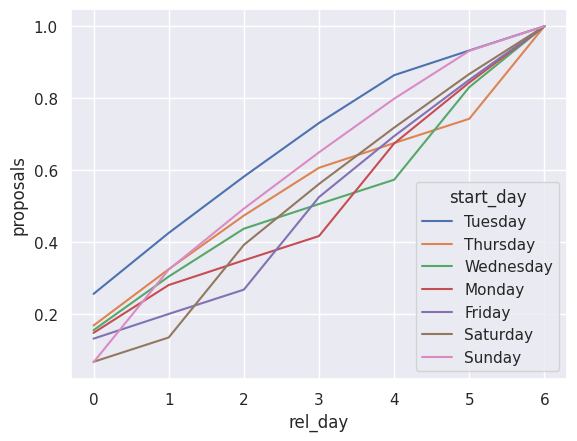

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

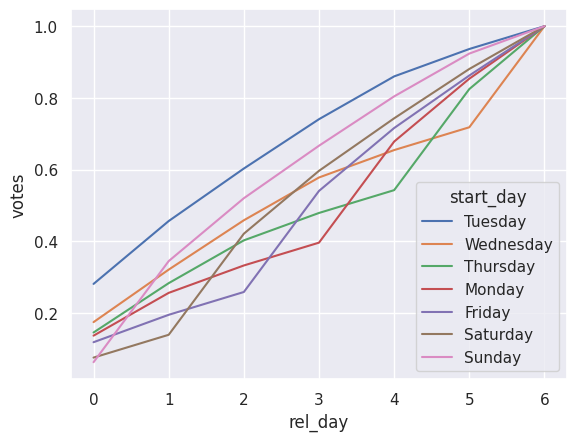

In [12]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

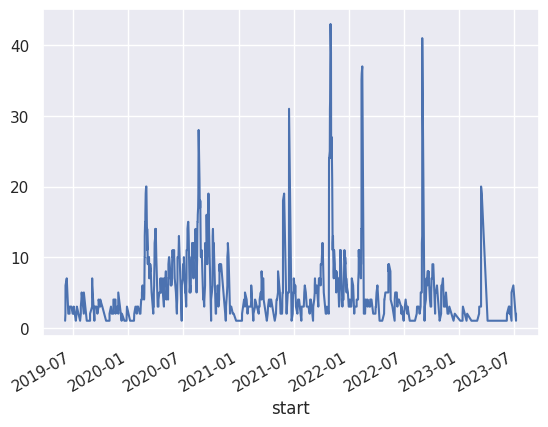

In [13]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [14]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                           W-SUN       W-MON       W-TUE  \
votes in open proposals (train) count  212.000000  212.000000  212.000000   
                                mean    23.235849   23.198113   22.575472   
                                std     22.444477   22.580208   22.528107   
                                min      0.000000    0.000000    0.000000   
                                50%     18.000000   17.500000   16.000000   
                                max     87.000000   89.000000   96.000000   
users in open proposals (train) count  212.000000  212.000000  212.000000   
                                mean    11.353774   11.349057   11.174528   
                                std      9.801941    9.867888   10.046938   
                                min      0.000000    0.000000    0.000000   
                                50%     10.000000   10.000000   10.000000   
                                max     41.000000   41.000000   42.000000   
open proposals                  count  212.000000  212.000000  212.000000   
                                mean     9.183962    9.235849    8.985849   
                                std     10.384966   10.544019   10.220544   
                                min      0.000000    0.000000    0.000000   
                                50%      7.000000    7.000000    7.000000   
                                max     57.000000   57.000000   55.000000   
votes in test                   count  212.000000  212.000000  212.000000   
                                mean     6.382075    6.490566    6.495283   
                                std      8.801673    8.631745    8.734362   
                                min      0.000000    0.000000    0.000000   
                                50%      3.000000    3.000000    3.000000   
                                max     57.000000   64.000000   64.000000   
users in test                   count  212.000000  212.000000  212.000000   
                                mean     3.820755    4.000000    4.037736   
                                std      4.613595    4.445563    4.797165   
                                min      0.000000    0.000000    0.000000   
                                50%      2.000000    2.000000    2.000000   
                                max     26.000000   18.000000   29.000000   
vpp test                        count  171.000000  172.000000  170.000000   
                                mean     0.809020    0.857803    0.934838   
                                std      0.951642    1.012012    1.322226   
                                min      0.000000    0.000000    0.000000   
                                50%      0.583333    0.581140    0.649123   
                                max      6.666667    6.000000   12.666667   
vpu test                        count  145.000000  146.000000  148.000000   
                                mean     1.778398    1.692886    1.725211   
                                std      1.812231    1.660153    1.550009   
                                min      1.000000    1.000000    1.000000   
                                50%      1.285714    1.250000    1.321839   
                                max     17.000000   17.000000   12.000000   

f                                           W-WED       W-THU       W-SAT  
votes in open proposals (train) count  212.000000  212.000000  213.000000  
                                mean    22.466981   22.872642   23.098592  
                                std     22.948817   22.762899   23.015881  
                                min      0.000000    0.000000    0.000000  
                                50%     15.000000   15.500000   18.000000  
                                max     88.000000   88.000000   85.000000  
users in open proposals (train) count  212.000000  212.000000  213.000000  
                                mean    11.000000   11.287736   11.262911  
    

In [15]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_3727418/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),4926.000000,4918.000000,4786.000000,4763.000000,4849.000000,4920.000000
users in open proposals (train),2407.000000,2406.000000,2369.000000,2332.000000,2393.000000,2399.000000
open proposals,1947.000000,1958.000000,1905.000000,1902.000000,1910.000000,1942.000000
votes in test,1353.000000,1376.000000,1377.000000,1224.000000,1255.000000,1289.000000
users in test,810.000000,848.000000,856.000000,800.000000,802.000000,805.000000
vpp test,138.342434,147.542148,158.922531,148.707747,144.372862,138.656713
vpu test,257.867702,247.161396,255.331217,250.075103,251.856153,253.215834


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [16]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [17]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [18]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [19]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2019-10-08 14:29:21)  =====
Currently open proposals: 0
Train votes in open proposals:   0
Test votes in open proposals:    0

===== Training on fold 1 (t: 2020-03-03 01:46:18)  =====
Currently open proposals: 9
Train votes in open proposals:   0
Test votes in open proposals:    9

===== Training on fold 2 (t: 2020-07-16 19:46:44)  =====
Currently open proposals: 16
Train votes in open proposals:  75
Test votes in open proposals:    4



===== Training on fold 3 (t: 2020-11-30 01:48:12)  =====
Currently open proposals: 14
Train votes in open proposals:  83
Test votes in open proposals:    5

===== Training on fold 4 (t: 2021-04-13 23:32:00)  =====
Currently open proposals: 7
Train votes in open proposals:  62
Test votes in open proposals:    3



===== Training on fold 5 (t: 2021-08-28 06:42:47)  =====
Currently open proposals: 8
Train votes in open proposals:  29
Test votes in open proposals:   10

===== Training on fold 6 (t: 2022-01-11 19:50:05)  =====
Currently open proposals: 11
Train votes in open proposals:  12
Test votes in open proposals:    5



===== Training on fold 7 (t: 2022-05-26 08:39:04)  =====
Currently open proposals: 4
Train votes in open proposals:  24
Test votes in open proposals:    0

===== Training on fold 8 (t: 2022-10-09 16:44:20)  =====
Currently open proposals: 8
Train votes in open proposals:  24
Test votes in open proposals:    2

===== Training on fold 9 (t: 2023-02-14 20:25:23)  =====
Currently open proposals: 2
Train votes in open proposals:   6
Test votes in open proposals:    2


In [20]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.077500,0.212025,0.179792,0.283333,0.048750,0.247646,0.196458,0.383333,0.032500,0.247646,0.196458,0.383333,0.285000,0.182500
std,0.103044,0.260895,0.228345,0.336100,0.055418,0.263325,0.226086,0.387298,0.036945,0.263325,0.226086,0.387298,0.279931,0.259554
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.100000
50%,0.025000,0.062500,0.041667,0.125000,0.037500,0.151552,0.083333,0.375000,0.025000,0.151552,0.083333,0.375000,0.250000,0.125000
75%,0.137500,0.453436,0.403125,0.500000,0.078125,0.497962,0.423958,0.687500,0.052083,0.497962,0.423958,0.687500,0.287500,0.143750
max,0.300000,0.598019,0.518750,0.833333,0.150000,0.598019,0.518750,1.000000,0.100000,0.598019,0.518750,1.000000,1.000000,0.900000


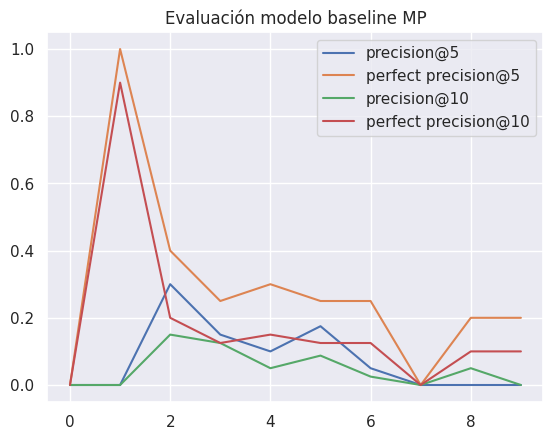

In [21]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.285000,0.800000,0.755556,0.755556,0.182500,0.800000,0.800000,0.800000,0.121667,0.800000,0.800000,0.800000
std,0.279931,0.421637,0.421637,0.421637,0.259554,0.421637,0.421637,0.421637,0.173036,0.421637,0.421637,0.421637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,1.000000,0.666667,0.666667,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000
50%,0.250000,1.000000,1.000000,1.000000,0.125000,1.000000,1.000000,1.000000,0.083333,1.000000,1.000000,1.000000
75%,0.287500,1.000000,1.000000,1.000000,0.143750,1.000000,1.000000,1.000000,0.095833,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,0.600000,1.000000,1.000000,1.000000


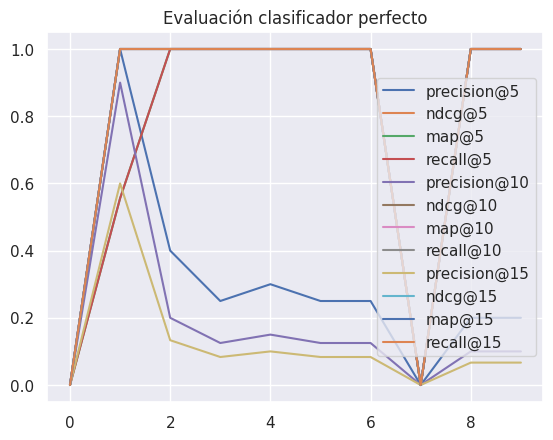

In [22]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [23]:
from tqdm.autonotebook import tqdm

In [24]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/212 [00:00<?, ?it/s]

Warning, empty test fold 0
Warning, empty test fold 1
Warning, empty test fold 2
Warning, empty test fold 3
Warning, empty test fold 4
Warning, empty test fold 5


Warning, empty test fold 6
Warning, empty test fold 7
Warning, empty test fold 8
Warning, empty test fold 9
Warning, empty test fold 10
Warning, empty test fold 11


Warning, empty test fold 12
Warning, empty test fold 13
Warning, empty test fold 14
Warning, empty test fold 15
Warning, empty test fold 16
Warning, empty test fold 17


Warning, empty test fold 18
Warning, empty test fold 19
Warning, empty test fold 20
Warning, empty test fold 21
Warning, empty test fold 22
Warning, empty test fold 23


Warning, empty test fold 24
Warning, empty test fold 25
Warning, empty test fold 26
Warning, empty test fold 27
Warning, empty test fold 28
Warning, empty test fold 29


Warning, empty test fold 30
Warning, empty test fold 31
Warning, empty test fold 32
Warning, empty test fold 33
Warning, empty test fold 34
Warning, empty test fold 35


Warning, empty test fold 36


Warning, empty test fold 40


Warning, empty test fold 44
Warning, empty test fold 45
Warning, empty test fold 48


Warning, empty test fold 51


Warning, empty test fold 54


Warning, empty test fold 81
Warning, empty test fold 82


Warning, empty test fold 89


Warning, empty test fold 106


Warning, empty test fold 163
Warning, empty test fold 164


Warning, empty test fold 167


Warning, empty test fold 176


Warning, empty test fold 180
Warning, empty test fold 182


Warning, empty test fold 184
Warning, empty test fold 185


Warning, empty test fold 198
Warning, empty test fold 200
Warning, empty test fold 201


Warning, empty test fold 203
Warning, empty test fold 204
Warning, empty test fold 205


Warning, empty test fold 207


Warning, empty test fold 211


In [25]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2019-06-06 09:49:38 2023-07-08 22:08:35


t0: 2019-06-13 00:00:00
t1: 2019-06-20 00:00:00
t-2: 2023-06-22 00:00:00
t-1: 2023-06-29 00:00:00


In [26]:
{ k:len(v) for k,v in metrics.items() }

{'t': 212,
 'precision@5': 212,
 'ndcg@5': 212,
 'map@5': 212,
 'recall@5': 212,
 'precision@10': 212,
 'ndcg@10': 212,
 'map@10': 212,
 'recall@10': 212,
 'precision@15': 212,
 'ndcg@15': 212,
 'map@15': 212,
 'recall@15': 212}

In [27]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2019-06-05 21:44:01')

Timestamp('2019-06-06 09:49:38')

,userID,itemID,timestamp,rating
164,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,a3cd7b01-435c-50cd-8d8c-75102df1027c,2019-06-06 09:49:38,1
165,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,83841f4c-18bf-57ef-bb9f-f0383b99fd32,2019-06-07 07:03:42,1
188,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,5c99eeb2-9854-5d2d-ba20-1ff1307ea924,2019-06-07 07:04:48,1
194,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,fc0c49e1-5e4a-528b-92e3-42b3fb560d16,2019-06-10 10:49:11,1
198,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,7179b537-bb7e-5677-adcd-3f44fcc78805,2019-06-10 10:49:31,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
32,daohaus,MetaCartel - MetaCartel Ventures,0x0372f3696fa7dc99801f435fd6737e57818239f2,a3cd7b01-435c-50cd-8d8c-75102df1027c,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-pro...,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,2019-06-05 21:44:01,,https://bit.ly/1thlYll,2019-06-05 21:44:01,NaT,1
270,daohaus,MetaCartel - MetaCartel Ventures,0x0372f3696fa7dc99801f435fd6737e57818239f2,83841f4c-18bf-57ef-bb9f-f0383b99fd32,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-pro...,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,2019-06-06 22:14:15,,nan,2019-06-06 22:14:15,NaT,1
146,daohaus,MetaCartel - MetaCartel Ventures,0x0372f3696fa7dc99801f435fd6737e57818239f2,5c99eeb2-9854-5d2d-ba20-1ff1307ea924,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-pro...,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,2019-06-06 22:18:23,,nan,2019-06-06 22:18:23,NaT,1
147,daohaus,MetaCartel - MetaCartel Ventures,0x0372f3696fa7dc99801f435fd6737e57818239f2,fc0c49e1-5e4a-528b-92e3-42b3fb560d16,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-pro...,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,2019-06-06 22:19:43,,nan,2019-06-06 22:19:43,NaT,1
733,daohaus,MetaCartel - MetaCartel Ventures,0x0372f3696fa7dc99801f435fd6737e57818239f2,7179b537-bb7e-5677-adcd-3f44fcc78805,b5c669ac-488c-5b91-82cc-e98add7af0b7,0x0372f3696fa7dc99801f435fd6737e57818239f2-pro...,0x865c2f85c9fea1c6ac7f53de07554d68cb92ed88,2019-06-06 22:31:28,,nan,2019-06-06 22:31:28,NaT,1


In [28]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,0.070521,0.224921,0.198408,0.289761,0.043130,0.245428,0.208328,0.348237,0.030107,0.248992,0.209454,0.360222,0.192928,0.103790,0.671693
std,0.092431,0.323603,0.311010,0.381978,0.050862,0.322789,0.309029,0.408320,0.034587,0.322307,0.308692,0.411042,0.181148,0.121249,0.468131
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.014286,0.058121,0.025811,0.066277,0.010317,0.073719,0.031331,0.122845,0.200000,0.100000,1.000000
75%,0.150000,0.386853,0.277778,0.571429,0.093182,0.409216,0.297619,0.750000,0.066667,0.409216,0.297619,0.758929,0.261538,0.130769,1.000000
max,0.400000,1.000000,1.000000,1.000000,0.200000,1.000000,1.000000,1.000000,0.133333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


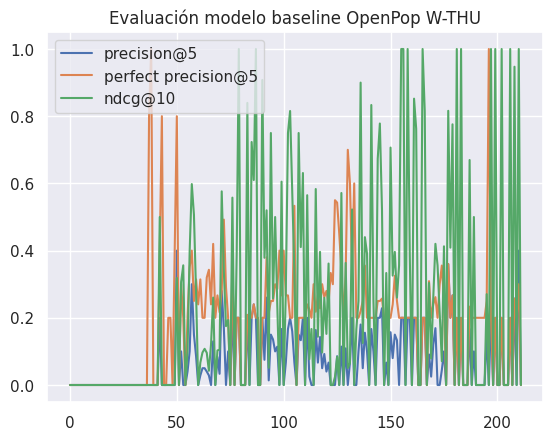

In [29]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [30]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.105714,0.394728,0.392857,0.400000,0.052857,0.394728,0.392857,0.400000,0.035238,0.394728,0.392857,0.400000,0.115714,0.057857,0.500000
std,0.146957,0.509818,0.507595,0.516398,0.073479,0.509818,0.507595,0.516398,0.048986,0.509818,0.507595,0.516398,0.125709,0.062854,0.527046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.050000,0.500000
75%,0.200000,0.986819,0.982143,1.000000,0.100000,0.986819,0.982143,1.000000,0.066667,0.986819,0.982143,1.000000,0.200000,0.100000,1.000000
max,0.400000,1.000000,1.000000,1.000000,0.200000,1.000000,1.000000,1.000000,0.133333,1.000000,1.000000,1.000000,0.300000,0.150000,1.000000


,t,model,variable,value
0,2019-06-10 10:49:41,openpop,precision@5,0.0
1,2019-06-16 11:31:19,openpop,precision@5,0.0
2,2019-06-26 18:47:29,openpop,precision@5,0.0
3,2019-06-27 00:22:50,openpop,precision@5,0.0
4,2019-07-09 21:38:11,openpop,precision@5,0.0
...,...,...,...,...
843,2023-05-25 02:56:45,perfect,recall@5,0.0
844,2023-06-07 22:19:55,perfect,recall@5,1.0
845,2023-06-14 04:18:45,perfect,recall@5,1.0
846,2023-06-20 05:20:06,perfect,recall@5,1.0


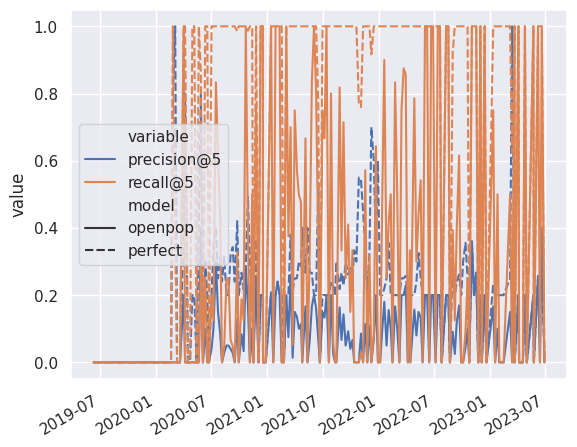

In [31]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [32]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2019-06-10 10:49:41,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
1,2019-06-16 11:31:19,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
2,2019-06-26 18:47:29,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
3,2019-06-27 00:22:50,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
4,2019-07-09 21:38:11,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2023-05-25 02:56:45,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,perfect
208,2023-06-07 22:19:55,0.257143,1.0,1.0,1.0,0.128571,1.0,1.0,1.0,0.085714,1.0,1.0,1.0,perfect
209,2023-06-14 04:18:45,0.200000,1.0,1.0,1.0,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,perfect
210,2023-06-20 05:20:06,0.300000,1.0,1.0,1.0,0.150000,1.0,1.0,1.0,0.100000,1.0,1.0,1.0,perfect


Cannot show ipywidgets in text

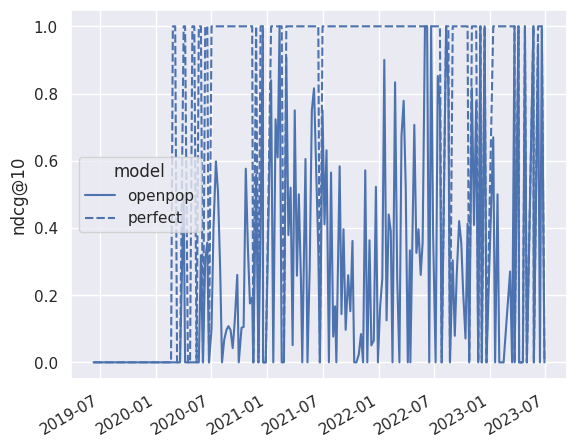

In [33]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [34]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.00,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,1.00,1.0,0.555556,0.555556,0.900,1.0,1.0,1.0,0.600000,1.0,1.0,1.0
2,0.40,1.0,1.000000,1.000000,0.200,1.0,1.0,1.0,0.133333,1.0,1.0,1.0
3,0.25,1.0,1.000000,1.000000,0.125,1.0,1.0,1.0,0.083333,1.0,1.0,1.0
4,0.30,1.0,1.000000,1.000000,0.150,1.0,1.0,1.0,0.100000,1.0,1.0,1.0
5,0.25,1.0,1.000000,1.000000,0.125,1.0,1.0,1.0,0.083333,1.0,1.0,1.0
6,0.25,1.0,1.000000,1.000000,0.125,1.0,1.0,1.0,0.083333,1.0,1.0,1.0
7,0.00,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8,0.20,1.0,1.000000,1.000000,0.100,1.0,1.0,1.0,0.066667,1.0,1.0,1.0
9,0.20,1.0,1.000000,1.000000,0.100,1.0,1.0,1.0,0.066667,1.0,1.0,1.0


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,0.192928,0.674528,0.664977,0.664977,0.103790,0.674528,0.671693,0.671693,0.071343,0.674528,0.673744,0.673744
std,0.181148,0.469660,0.466524,0.466524,0.121249,0.469660,0.468131,0.468131,0.091943,0.469660,0.469154,0.469154
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000
75%,0.261538,1.000000,1.000000,1.000000,0.130769,1.000000,1.000000,1.000000,0.087179,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.866667,1.000000,1.000000,1.000000


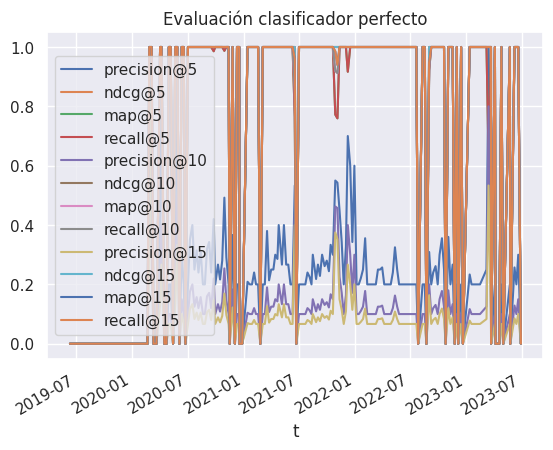

In [35]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [36]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 212 folds
From 2019-06-06 09:49:38 to 2023-07-08 22:08:35


,train,test,open,test users,test vpv,test vpp
count,212.000000,212.000000,212.000000,212.000000,153.000000,153.000000
mean,1652.396226,6.485849,9.051887,4.146226,0.776709,1.929014
std,1113.943294,9.539878,10.370033,5.399871,0.248829,2.229408
min,6.000000,0.000000,0.000000,0.000000,0.076923,0.076923
25%,509.000000,0.000000,1.000000,0.000000,0.615385,1.000000
50%,1675.000000,3.000000,7.000000,2.000000,0.818182,1.333333
75%,2689.000000,9.000000,12.000000,6.000000,1.000000,2.000000
max,3285.000000,56.000000,52.000000,31.000000,1.000000,18.000000


In [37]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2019-06-13,6,0,0,0,NaN,NaN,NaT,NaT
1,2019-06-20,7,0,0,0,NaN,NaN,NaT,NaT
2,2019-06-27,10,0,0,0,NaN,NaN,NaT,NaT
3,2019-07-04,11,0,0,0,NaN,NaN,NaT,NaT
4,2019-07-11,14,0,0,0,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...
207,2023-06-01,3246,0,0,0,NaN,NaN,NaT,NaT
208,2023-06-08,3253,9,2,7,0.777778,3.500000,2023-06-08 05:07:25,2023-06-14 04:18:45
209,2023-06-15,3262,1,3,1,1.000000,1.000000,2023-06-23 16:26:59,2023-06-23 16:26:59
210,2023-06-22,3275,3,3,2,0.666667,0.666667,2023-06-22 14:41:18,2023-06-23 16:26:59


In [38]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 72 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window
67,2020-09-24,902,51,34,23,0.450980,2.090909,2020-09-24 03:49:31,2020-10-07 18:51:10,True,True
68,2020-10-01,952,1,24,1,1.000000,1.000000,2020-10-07 18:51:10,2020-10-07 18:51:10,True,True
69,2020-10-08,973,23,19,16,0.695652,2.666667,2020-10-08 01:53:44,2020-10-23 13:52:37,True,True
70,2020-10-15,1003,15,17,14,0.933333,4.666667,2020-10-15 16:50:41,2020-10-23 13:52:37,True,True
71,2020-10-22,1050,7,11,5,0.714286,1.250000,2020-10-22 12:56:07,2020-10-23 13:52:37,True,True
72,2020-10-29,1075,33,14,13,0.393939,1.625000,2020-10-29 00:25:32,2020-11-09 15:02:25,True,True
73,2020-11-05,1105,16,13,11,0.687500,1.833333,2020-11-06 13:12:42,2020-11-15 12:16:09,True,True
128,2021-11-25,2134,3,12,3,1.000000,1.000000,2021-11-25 18:15:40,2022-04-26 15:58:45,True,True
129,2021-12-02,2153,18,12,11,0.611111,1.571429,2021-12-02 16:41:35,2022-04-26 15:58:45,True,True
130,2021-12-09,2176,8,14,2,0.250000,0.333333,2021-12-09 23:36:55,2022-04-26 15:58:45,True,True


In [39]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 50 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window


            train  test  i
t                         
2019-06-13      6     0  0
2019-06-20      7     0  1
2019-06-27     10     0  2
2019-07-04     11     0  3
2019-07-11     14     0  4
2019-07-18     18     0  5
2019-07-25     18     0  6
2019-08-01     39     0  7
2019-08-08     52     0  8
2019-08-15     59     0  9


Cannot show ipywidgets in text

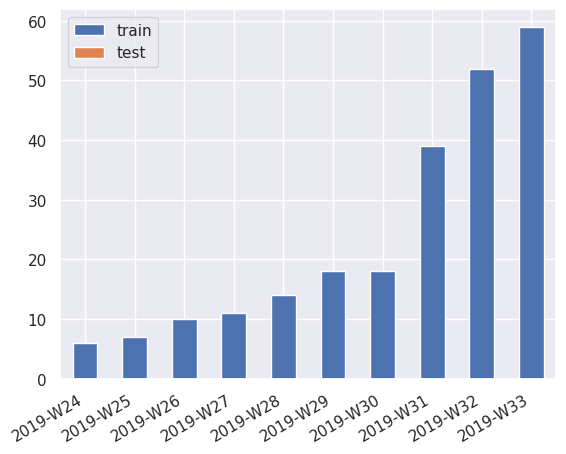

In [40]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

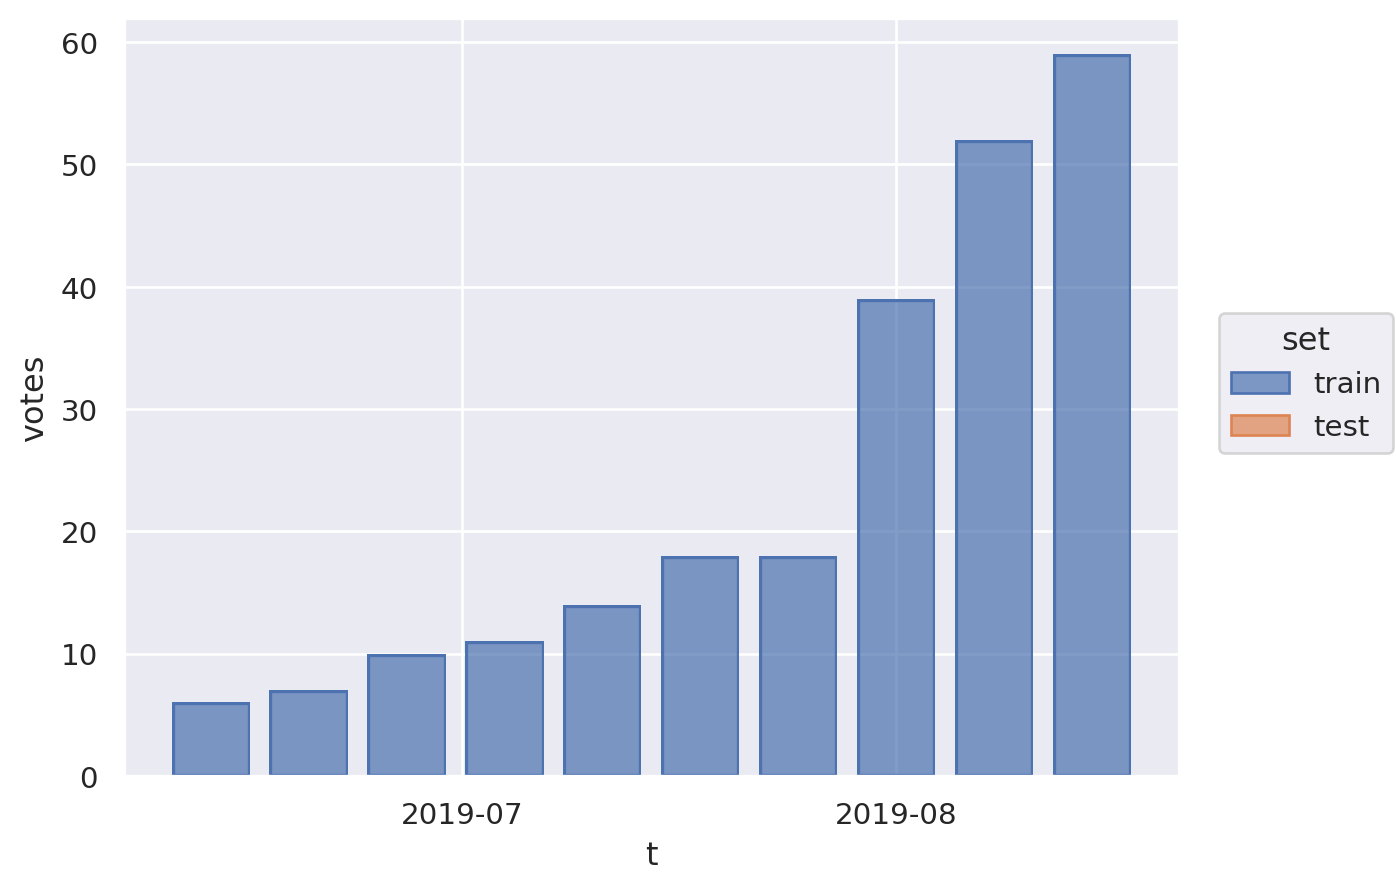

In [41]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())